/tmp/ipykernel_28244/804691801.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
/home/yfliu/anaconda3/envs/hifigan/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


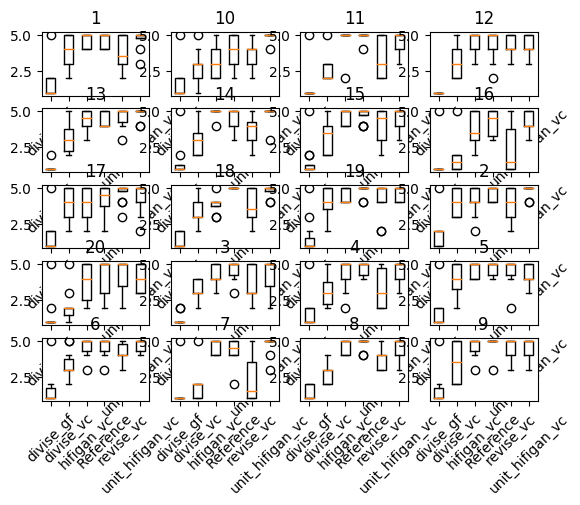

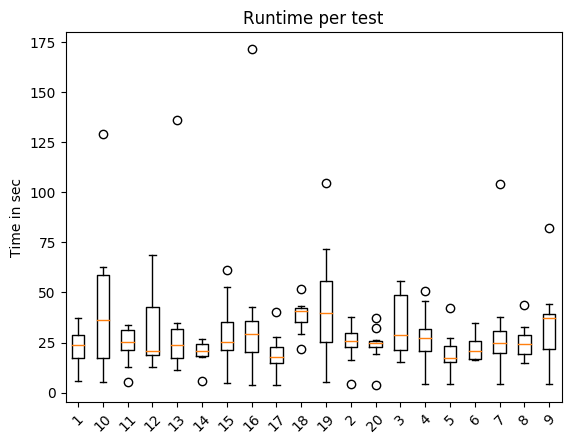

In [18]:
import json
import math
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import collections


ResultsExt = ".txt"
ResultsFolder = "/home/yfliu/beaqlejs/results/"

# Check if folder with results exists and retrieve list of all result files
if os.path.exists(ResultsFolder):
    dirListing = os.listdir(ResultsFolder)
    dirListing = [name for name in dirListing if name.endswith(ResultsExt)]
    if len(dirListing) < 1:
        print("ERROR: empty ResultsFolder!")
        raise SystemExit()
else:
    print("ERROR: invalid ResultsFolder!")
    raise SystemExit()

# Import and decode all result files
ResJSONList = list()
ResMetaData = list()
for ResFileName in dirListing:
    ResFile = open(os.path.join(ResultsFolder, ResFileName))
    ResMetaStruct = collections.OrderedDict()
    ResMetaStruct['FileName'] = ResFileName
    ResMetaStruct['UserID'] = -1
    ResMetaStruct['UserName'] = ""
    ResMetaStruct['UserEmail'] = ""
    ResMetaStruct['UserComment'] = ""
    try:
        ResJSONList.append(json.load(ResFile))
        ResMetaData.append(ResMetaStruct)
    except:
        print(os.path.join(ResultsFolder, ResFileName) + " is not a valid JSON file.")
    finally:
        ResFile.close()

# Group results by test sets
numResults = len(ResJSONList)
RatingsDict = dict()
RuntimesDict = dict()
for n, ResJSONData in enumerate(ResJSONList):
    ResMetaData[n]['UserID'] = n
    for i in range(0, len(ResJSONData)):
        if 'TestID' in ResJSONData[i]:
            testID = ResJSONData[i]['TestID']

            if testID not in RatingsDict:
                RatingsDict[testID] = dict()

            if testID not in RuntimesDict:
                RuntimesDict[testID] = list()

            # if runtime entry exists
            if 'Runtime' in ResJSONData[i]:
                RuntimesDict[testID].append(ResJSONData[i]['Runtime'])

            # if rating entry exists
            if 'rating' in ResJSONData[i]:
                for testItem in ResJSONData[i]['rating']:
                    if testItem not in RatingsDict[testID]:
                        RatingsDict[testID][testItem] = list()
                    RatingsDict[testID][testItem].append(ResJSONData[i]['rating'][testItem])

        elif 'UserComment' in ResJSONData[i]:
            ResMetaData[n]['UserName'] = ResJSONData[i]['UserName']
            ResMetaData[n]['UserEmail'] = ResJSONData[i]['UserEmail']
            ResMetaData[n]['UserComment'] = ResJSONData[i]['UserComment']

# write csv file with metadata to map columns of the CSV file
CsvFile = open('metadata.csv', 'w')
fieldnames = ResMetaData[0].keys()
CsvWriter = csv.DictWriter(CsvFile, fieldnames=fieldnames, delimiter="\t")
for ResMetaStruct in ResMetaData:
    try:
        CsvWriter.writerow(ResMetaStruct)
    except:
        pass
CsvFile.close()

# plot and evaluate every single test set, output results to a csv file
numTests = sum(1 for dict in ResJSONList[0] if 'TestID' in dict)
plotsX = math.ceil(np.sqrt(numTests))
plotsY = math.ceil(numTests / plotsX)
plotInd = 0
for testID in sorted(RatingsDict, key=lambda s: s.lower()):

    # write test set results to a csv file
    CsvFile = open(testID + '.csv', 'w')
    CsvWriter = csv.writer(CsvFile)

    testResArr = None
    labels = list()
    for testDataKey in sorted(RatingsDict[testID], key=lambda s: s.lower()):
        testData = RatingsDict[testID][testDataKey]
        row = list()
        row.append(testDataKey)
        row.extend(testData)
        CsvWriter.writerow(row)
        npTestData = np.array(testData)
        labels.append(testDataKey)
        if testResArr is None:
            testResArr = npTestData
        else:
            testResArr = np.column_stack((testResArr, npTestData.T))

    CsvFile.close()

    plotInd += 1
    if testResArr.shape[0] > 1:
        plt.figure(0)
        plt.subplot(plotsX, plotsY, plotInd)
        plt.boxplot(testResArr)
        plt.title(testID.replace('mos测试_', ''))
        plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
    else:
        print("WARNING: not enough ratings for test " + testID + " to create a boxplot!")

plt.tight_layout()

# plot runtime of tests
runtimesArr = list()
labels = list()
for testID in sorted(RuntimesDict, key=lambda s: s.lower()):
    timesInSec = [x / 1000 for x in RuntimesDict[testID]]
    runtimesArr.append(timesInSec)
    labels.append(testID.replace('mos测试_', ''))

plt.figure(1)
plt.boxplot(runtimesArr)
plt.title("Runtime per test")
plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel("Time in sec")

plt.show()


In [19]:
RatingsDict

# Function to calculate MOS and confidence interval
def calculate_mos_and_ci(scores):
    n = len(scores)
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)  # Sample standard deviation
    ci = 1.96 * (std / np.sqrt(n))  # 95% confidence interval
    return mean, ci

# Calculate MOS and CI for each category in each test
final_mos_scores = {}
for test_name, categories in RatingsDict.items():
    final_mos_scores[test_name] = {}
    for category, scores in categories.items():
        mean, ci = calculate_mos_and_ci(scores)
        final_mos_scores[test_name][category] = f"{mean:.2f}±{ci:.2f}"

# Print final MOS scores with confidence intervals
for test_name, categories in final_mos_scores.items():
    print(f"Results for {test_name}:")
    for category, mos_score in categories.items():
        print(f"{category}: {mos_score}")

Results for mos测试_1:
hifigan_vc: 4.62±0.36
Reference: 4.62±0.36
unit_hifigan_vc: 4.62±0.52
divise_vc: 3.88±0.78
divise_gf: 1.75±0.96
revise_vc: 3.75±0.81
Results for mos测试_2:
divise_vc: 4.11±0.61
divise_gf: 1.89±0.83
revise_vc: 4.00±0.73
Reference: 4.67±0.33
hifigan_vc: 4.00±0.65
unit_hifigan_vc: 4.78±0.29
Results for mos测试_3:
unit_hifigan_vc: 4.30±0.72
Reference: 4.60±0.43
hifigan_vc: 4.30±0.42
revise_vc: 3.60±0.78
divise_vc: 3.20±0.49
divise_gf: 1.20±0.26
Results for mos测试_4:
divise_gf: 1.70±0.78
hifigan_vc: 4.30±0.66
divise_vc: 3.10±0.62
revise_vc: 3.30±0.83
Reference: 4.70±0.30
unit_hifigan_vc: 4.50±0.44
Results for mos测试_5:
Reference: 4.70±0.30
divise_gf: 1.70±0.78
divise_vc: 4.00±0.65
revise_vc: 4.50±0.60
unit_hifigan_vc: 4.20±0.49
hifigan_vc: 4.60±0.32
Results for mos测试_6:
revise_vc: 4.10±0.46
unit_hifigan_vc: 4.70±0.30
divise_gf: 1.60±0.78
divise_vc: 3.30±0.66
Reference: 4.60±0.43
hifigan_vc: 4.60±0.43
Results for mos测试_7:
unit_hifigan_vc: 4.70±0.42
hifigan_vc: 4.60±0.32
divise

In [20]:
import numpy as np
import scipy.stats as stats

# Function to calculate MOS and confidence interval
def calculate_mos_and_ci(scores):
    n = len(scores)
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)  # Sample standard deviation
    ci = 1.96 * (std / np.sqrt(n))  # 95% confidence interval
    return mean, ci

# Combine scores for each method across all tests
combined_scores = {}
for test_name, categories in RatingsDict.items():
    for category, scores in categories.items():
        if category not in combined_scores:
            combined_scores[category] = []
        combined_scores[category].extend(scores)

# Calculate overall MOS and CI for each method
final_mos_scores = {}
for category, scores in combined_scores.items():
    mean, ci = calculate_mos_and_ci(scores)
    final_mos_scores[category] = f"{mean:.2f}±{ci:.2f}"

# Print final MOS scores with confidence intervals
print("Overall MOS Scores:")
for category, mos_score in final_mos_scores.items():
    print(f"{category}: {mos_score}")


Overall MOS Scores:
hifigan_vc: 4.30±0.12
Reference: 4.53±0.11
unit_hifigan_vc: 4.51±0.10
divise_vc: 3.16±0.17
divise_gf: 1.50±0.15
revise_vc: 3.83±0.17
